In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.python.keras.models import load_model
import numpy as np
import tensorflow as tf

WIDTH_SIZE = 224
HEIGHT_SIZE = 224
CHANNELS = 3

from tensorflow.keras.optimizers import Adam

# Define custom optimizer
class CustomAdam(Adam):
    def __init__(self, learning_rate=0.001, **kwargs):
        super(CustomAdam, self).__init__(learning_rate=learning_rate, **kwargs)

# Register custom optimizer
tf.keras.utils.register_keras_serializable(package='Custom', name='CustomAdam')(CustomAdam)

# Загружаем модель
# model = tf.keras.models.load_model('/content/drive/MyDrive/best_1.h5', custom_objects={'CustomAdam': CustomAdam})


# Загружаем изображение
img_path = r'/content/drive/MyDrive/Datasets/photo_2024-03-24_20-51-03.jpg'  # Путь к вашему изображению
img =  tf.keras.utils.load_img(img_path, target_size=(HEIGHT_SIZE, WIDTH_SIZE, CHANNELS))
img_array = np.array(img) / 255.0  # Нормализуем значения пикселей
img_array = np.expand_dims(img_array, axis=0)  # Добавляем размерность пакета

# Получаем предсказание модели
predictions = model.predict(img_array)[0]

# Определяем класс предсказания
class_labels = ['melanoma', 'nevus', 'seborrheic_keratosis']
prediction_class = class_labels[np.argmax(predictions)]

# Отображаем результат
print(f'Predicted class: {prediction_class}')
print(f'Probabilities: m: {predictions[0]:.2%}, n: {predictions[1]:.2%}, s: {predictions[2]:.2%}')


1/1 [==============================] - 0s 110ms/step
Predicted class: nevus
Probabilities: m: 0.02%, n: 99.96%, s: 0.02%


In [ ]:
!unzip '/content/drive/MyDrive/Datasets/skin-lesions_2.zip'

Archive:  /content/drive/MyDrive/Datasets/skin-lesions_2.zip
   creating: skin-lesions_2/
   creating: skin-lesions_2/melanoma/
  inflating: skin-lesions_2/melanoma/ISIC_0000002.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000004.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000013.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000022.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000026.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000029.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000030.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000031.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000035.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000036.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000040.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000043.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000046.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000049.jpg  
  inflating: skin-lesions_2/melanoma/ISIC_0000054.jpg  
  inflating: skin-lesions_2/mela

In [ ]:
DATA_PATH = '/content/skin-lesions_2'

In [ ]:
from pathlib import Path
import pandas as pd
import os

# для последующего анализа преобразуем пути к картинкам, в датафрейм (file_paths\labels)
def convert_data_to_df(data_path):
    data_dir = Path(data_path)

    # ищем все изображения в data_dir
    file_paths = list(data_dir.glob(r'**/*.JPG'))\
               + list(data_dir.glob(r'**/*.jpg'))\
               + list(data_dir.glob(r'**/*.jpeg'))\
               + list(data_dir.glob(r'**/*.PNG'))

    # получаем мтеки
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_paths))

    # делаем dataFrame
    data_df = pd.DataFrame({'File_path' : file_paths,
                            'Label' : labels})

    return data_df

DATA_DF = convert_data_to_df(DATA_PATH)
DATA_DF.head()
# print(DATA_DF['File_path'][0].dtype())

,File_path,Label
0,/content/skin-lesions_2/seborrheic_keratosis/I...,seborrheic_keratosis
1,/content/skin-lesions_2/seborrheic_keratosis/I...,seborrheic_keratosis
2,/content/skin-lesions_2/seborrheic_keratosis/I...,seborrheic_keratosis
3,/content/skin-lesions_2/seborrheic_keratosis/I...,seborrheic_keratosis
4,/content/skin-lesions_2/seborrheic_keratosis/I...,seborrheic_keratosis


In [ ]:
import numpy as np
from sklearn.utils import resample

# Новые данные генерируются путем копирования записей из классов меньшинства для увеличения количества выборок
'''
нужно для того, чтобы сбалансировать распределение классов в наборе данных, что может
повысить производительность моделей машинного обучения. Увеличивая количество выборок
в классах меньшинства, модель может узнать больше об этих классах и сделать более
точные прогнозы.
'''

# словарь уникальных меток и соответствующих им индексов
feature_names = {i: label for i, label in enumerate(DATA_DF['Label'].unique())}

def upsample(df, path_name, label_name, n_samples = max(DATA_DF['Label'].value_counts())):
    # находим индексы строк с метками в словаре Feature_names и удаляем их
    upsample_idx = [i for i, label in enumerate(df[label_name])
                      if label in feature_names.values()]

    new_df = df.drop(df.index[upsample_idx])

    # повторно дискретизируем оставшиеся строки, чтобы на каждую метку было n_samples
    resampled_df = df.iloc[upsample_idx].groupby(label_name).apply(lambda x: resample(x, n_samples=n_samples, random_state=0))
    resampled_df.index = resampled_df.index.droplevel(0)

    new_df = pd.concat([new_df, resampled_df])

    return new_df[[path_name, label_name]]

up_data_df = upsample(DATA_DF, 'File_path', 'Label')

up_data_df

,File_path,Label
2498,/content/skin-lesions_2/melanoma/ISIC_0000413.jpg,melanoma
2665,/content/skin-lesions_2/melanoma/ISIC_0014077.jpg,melanoma
2315,/content/skin-lesions_2/melanoma/ISIC_0014695.jpg,melanoma
2583,/content/skin-lesions_2/melanoma/ISIC_0011118.jpg,melanoma
2376,/content/skin-lesions_2/melanoma/ISIC_0000412.jpg,melanoma
...,...,...
202,/content/skin-lesions_2/seborrheic_keratosis/I...,seborrheic_keratosis
133,/content/skin-lesions_2/seborrheic_keratosis/I...,seborrheic_keratosis
340,/content/skin-lesions_2/seborrheic_keratosis/I...,seborrheic_keratosis
439,/content/skin-lesions_2/seborrheic_keratosis/I...,seborrheic_keratosis


In [ ]:
up_data_df = up_data_df.astype('string')

In [ ]:
# разделим даные на выборки
from sklearn.model_selection import train_test_split

train_valid_df, test_df = train_test_split(up_data_df, test_size = 0.2, random_state = 1)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2, random_state = 1)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f'train_df: {train_df.shape}\nvalid_df: {valid_df.shape}\ntest_df: {test_df.shape}')

train_df: (3538, 2)
valid_df: (885, 2)
test_df: (1106, 2)


In [ ]:
WIDTH_SIZE = 224
HEIGHT_SIZE = 224
CHANNELS = 3
BATCH_SIZE = 8

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_datagen = ImageDataGenerator(rescale=1/255,
                                 rotation_range=20,
                                 zoom_range=0.1,
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='nearest')

train_generator = img_datagen.flow_from_dataframe(train_df,
                                                  x_col = 'File_path',
                                                  y_col = 'Label',
                                                  target_size = (HEIGHT_SIZE, WIDTH_SIZE),
                                                  color_mode='rgb',
                                                  class_mode = 'categorical',
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True,
                                                  seed = 0)

valid_generator = img_datagen.flow_from_dataframe(valid_df,
                                                  x_col = 'File_path',
                                                  y_col = 'Label',
                                                  target_size = (HEIGHT_SIZE, WIDTH_SIZE),
                                                  color_mode='rgb',
                                                  class_mode = 'categorical',
                                                  batch_size = BATCH_SIZE,
                                                  shuffle = True,
                                                  seed = 0)

test_generator = img_datagen.flow_from_dataframe(test_df,
                                                 x_col = 'File_path',
                                                 y_col = 'Label',
                                                 target_size = (HEIGHT_SIZE, WIDTH_SIZE),
                                                 color_mode='rgb',
                                                 class_mode = 'categorical',
                                                 batch_size = BATCH_SIZE,
                                                 shuffle = True,
                                                 seed = 1)

Found 3538 validated image filenames belonging to 3 classes.
Found 885 validated image filenames belonging to 3 classes.
Found 1106 validated image filenames belonging to 3 classes.


In [ ]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from tensorflow.keras.utils import load_img

IMAGE_SIZE = (WIDTH_SIZE, HEIGHT_SIZE)

# Загружаем модель и выполняем предсказания для тестовых данных
predictions = []
for filename in tqdm(test_df['File_path'], desc="Predicting"):
    img = load_img(filename, target_size=IMAGE_SIZE)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions.append(np.argmax(model.predict(img_array, verbose=0)))

# Загружаем истинные метки тестовых данных
true_labels = test_df['Label'].map({'melanoma': 0, 'nevus': 1, 'seborrheic_keratosis': 2})

# Создаем матрицу ошибок
conf_matrix = confusion_matrix(true_labels, predictions)

Predicting: 100%|██████████| 1106/1106 [03:57<00:00,  4.66it/s]


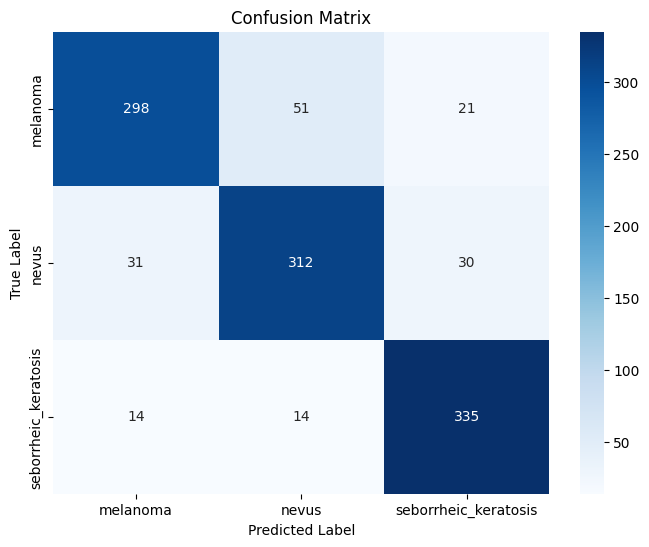

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = ['melanoma', 'nevus', 'seborrheic_keratosis']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()